# **Data Study Notebook**

## Objectives

- Answer Business Requirement 1: The client is interested in discovering how house attributes correlate with the sale price.

## Inputs

- outputs/datasets/collection/HousePrices.csv

## Outputs

- Generate code that answers business requirement 1 and can be used to build Streamlit App
- Save plots in folder for documentation


---

# Change working directory

In [1]:
import os

# Set working directory to project root
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print("Working directory set to", os.getcwd())

Working directory set to /workspaces/heritage-housing


## Load Cleaned Data

In [2]:
import pandas as pd

df = pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv")
print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,1828,0.0,3.0,Av,48,Unf,1774,NaN,774,Unf,...,90.0,452.0,108,5,9,1822,NaN,2007,2007,314813
1,894,0.0,2.0,No,0,Unf,894,NaN,308,Unf,...,60.0,0.0,0,5,5,894,NaN,1962,1962,109500
2,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,80.0,0.0,0,7,5,876,NaN,1921,2006,163500
3,1689,0.0,3.0,No,1218,GLQ,350,NaN,857,RFn,...,69.0,148.0,59,5,8,1568,NaN,2002,2002,271000
4,1541,0.0,3.0,No,0,Unf,1541,NaN,843,RFn,...,118.0,150.0,81,5,7,1541,NaN,2001,2002,205000


## Data Exploration

In [3]:
from pandas_profiling import ProfileReport

pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

/tmp/ipykernel_21681/4260182695.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Create a new directory to save plots

In [4]:
import os

try:
    os.makedirs("docs/plots")
except Exception as e:
    print(e)

[Errno 17] File exists: 'docs/plots'


Suppress Warnings

In [5]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="ppscore.calculation")

---

## Correlation and PPS Analysis

In [6]:
%matplotlib inline

import numpy as np
import ppscore as pps
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt



def heatmap_corr(df,threshold, figsize=(22,12), font_annot = 9):
  """
  Function to create heatmap using correlations.
  """
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    if df.name == "corr_spearman":
      plt.savefig(f'docs/plots/heatmap_corr_spearman.png', bbox_inches='tight')
    else:
      plt.savefig(f'docs/plots/heatmap_corr_pearson.png', bbox_inches='tight')
    plt.show()


def heatmap_pps(df,threshold, figsize=(22,12), font_annot = 9):
    """
    Function to create heatmap using pps.
    """
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.savefig(f'docs/plots/heatmap_pps.png', bbox_inches='tight')
      plt.show()


def CalculateCorrAndPPS(df):
    """
    Function to calculate correlations and pps.
    df: full dataframe with numerical and categorical variables
    """
    df_num = df.select_dtypes(include=["number"])

    df_corr_spearman = df_num.corr(method="spearman")
    df_corr_spearman.name = 'corr_spearman'

    df_corr_pearson = df_num.corr(method="pearson")
    df_corr_pearson.name = 'corr_pearson'

    pps_matrix_raw = pps.matrix(df)  
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1")[['ppscore']].describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix



def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(22,12), font_annot=9 ):
  """
  Function to display the correlations and pps.
  """

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi-colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [8]:
import warnings
warnings.filterwarnings("ignore", message=".*least populated class.*")


df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count  mean    std  min  25%  50%    75%    max
ppscore  552.0  0.05  0.099  0.0  0.0  0.0  0.055  0.619




* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



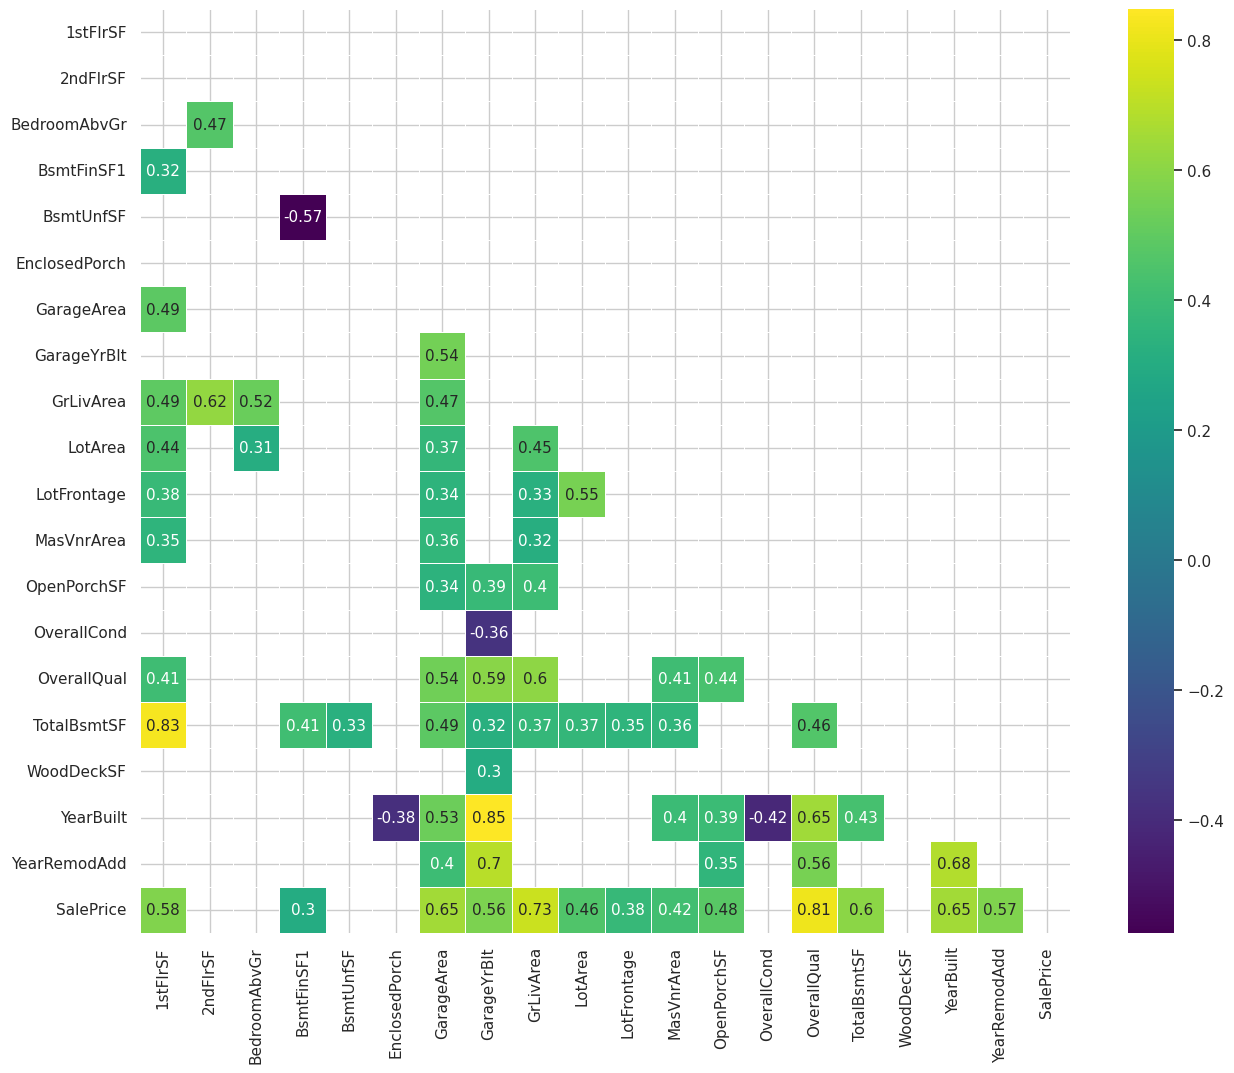



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



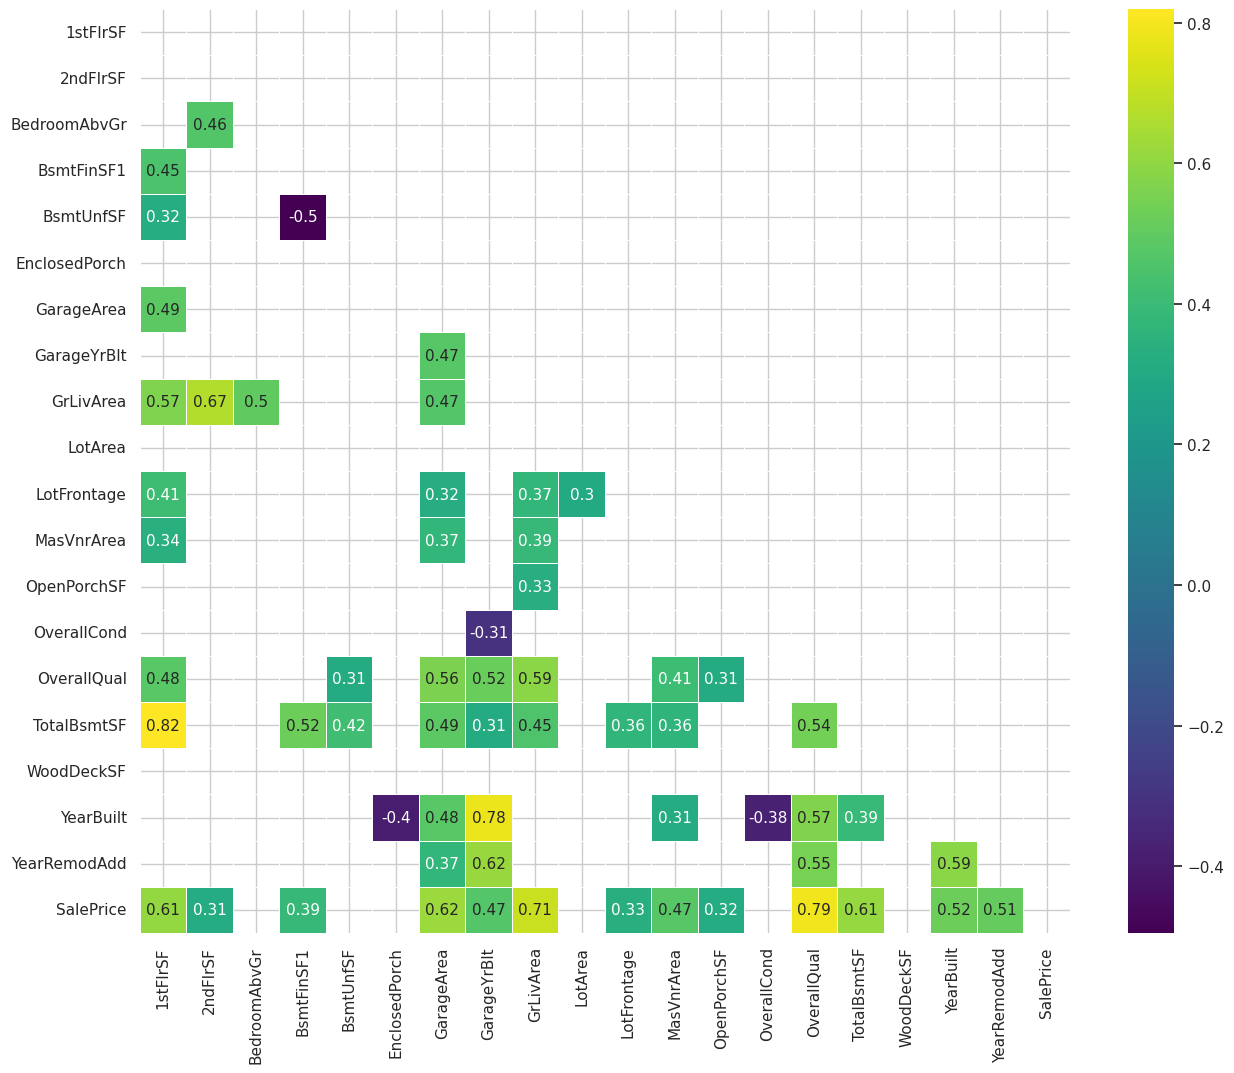



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



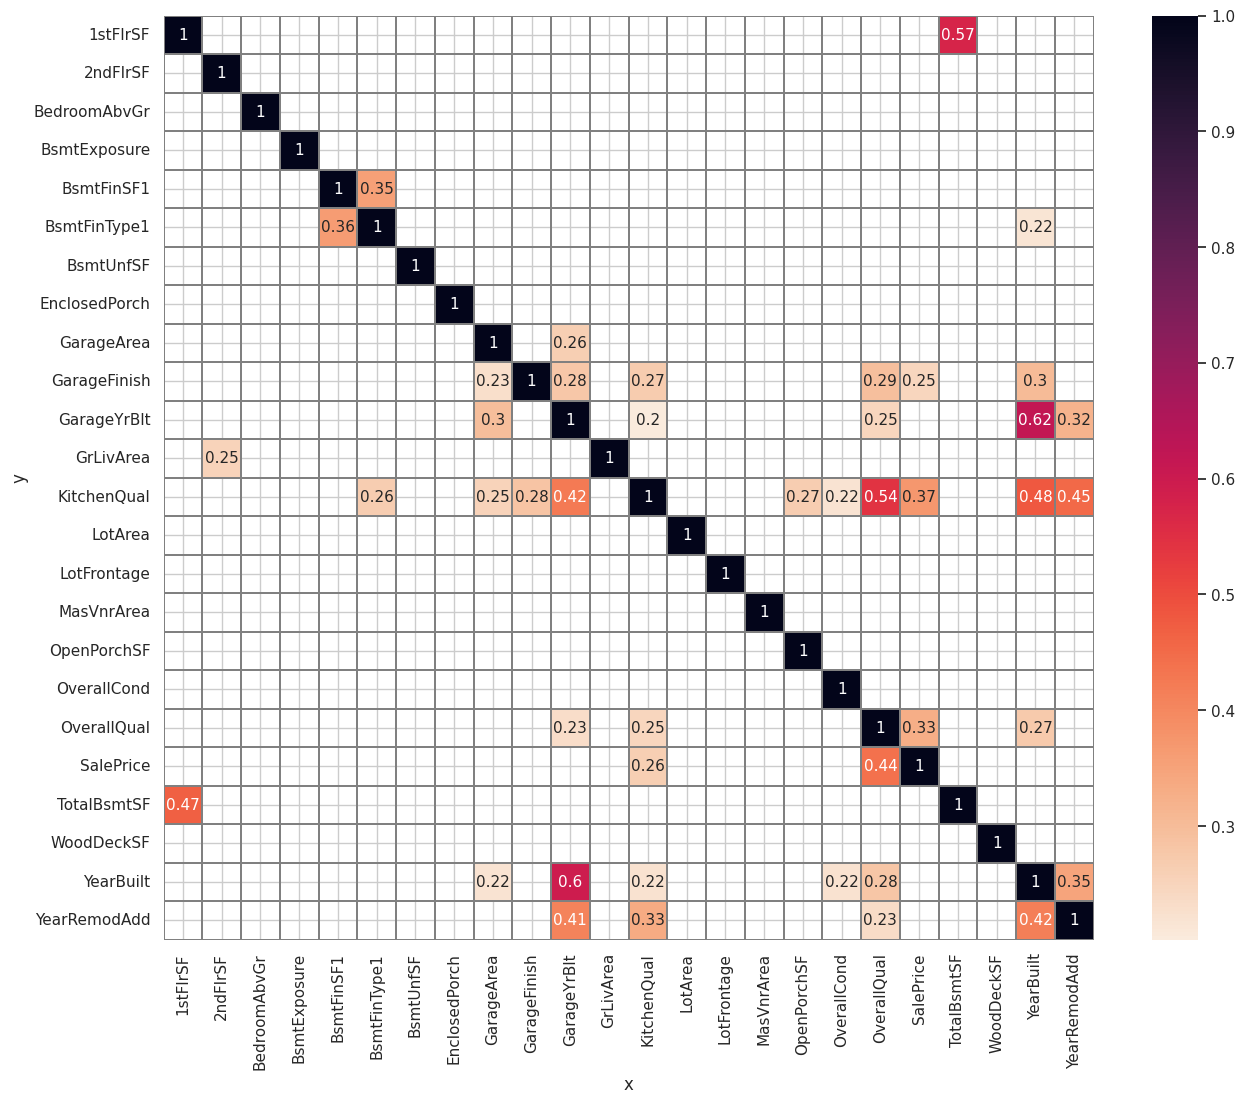

In [9]:
DisplayCorrAndPPS(
    df_corr_pearson=df_corr_pearson,
    df_corr_spearman=df_corr_spearman,
    pps_matrix=pps_matrix,
    CorrThreshold=0.3,
    PPS_Threshold=0.2,
    figsize=(15, 12),
    font_annot=11,
)

In [12]:
corr_spearman = (
    df.select_dtypes(include=["number"])  
    .corr(method="spearman")["SalePrice"]
    .sort_values(key=abs, ascending=False)[1:]
    .head(10)
)
corr_spearman

OverallQual     0.809829
GrLivArea       0.731310
YearBuilt       0.652682
GarageArea      0.649379
TotalBsmtSF     0.602725
1stFlrSF        0.575408
YearRemodAdd    0.571159
GarageYrBlt     0.564694
OpenPorchSF     0.477561
LotArea         0.456461
Name: SalePrice, dtype: float64

In [13]:
corr_pearson = (
    df.select_dtypes(include=["number"])
    .corr(method="pearson")["SalePrice"]
    .sort_values(key=abs, ascending=False)[1:]
    .head(10)
)
corr_pearson

OverallQual     0.790982
GrLivArea       0.708624
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
GarageYrBlt     0.469056
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

In [14]:
top_n = 10
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'1stFlrSF',
 'BsmtFinSF1',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'LotArea',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

In [15]:
vars_to_study = [
    "1stFlrSF",
    "BsmtFinSF1",
    "GarageArea",
    "GarageYrBlt",
    "GrLivArea",
    "LotArea",
    "MasVnrArea",
    "OpenPorchSF",
    "OverallQual",
    "TotalBsmtSF",
    "YearBuilt",
    "YearRemodAdd",
]
vars_to_study

['1stFlrSF',
 'BsmtFinSF1',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'LotArea',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

## EDA on selected variables

In [16]:
df_eda = df.filter(vars_to_study + ["SalePrice"])
df_eda.head(10)

,1stFlrSF,BsmtFinSF1,GarageArea,GarageYrBlt,GrLivArea,LotArea,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1828,48,774,2007.0,1828,11694,452.0,108,9,1822,2007,2007,314813
1,894,0,308,1962.0,894,6600,0.0,0,5,894,1962,1962,109500
2,964,713,432,1921.0,964,13360,0.0,0,5,876,1921,2006,163500
3,1689,1218,857,2002.0,1689,13265,148.0,59,8,1568,2002,2002,271000
4,1541,0,843,2001.0,1541,13704,150.0,81,7,1541,2001,2002,205000
5,1221,410,400,2004.0,1221,7500,0.0,113,7,1221,2004,2005,185000
6,1324,643,440,1965.0,1324,8658,101.0,138,6,1088,1965,1965,160000
7,696,604,484,1999.0,1416,2572,0.0,44,7,696,1999,1999,155000
8,526,462,297,1973.0,988,1596,0.0,101,4,462,1973,1973,91000
9,869,375,440,2003.0,1218,6000,0.0,0,6,735,1941,1950,131000


## Variables Distribution by SalesPrice

We plot the distribution (numerical and categorical) coloured by SalesPrice

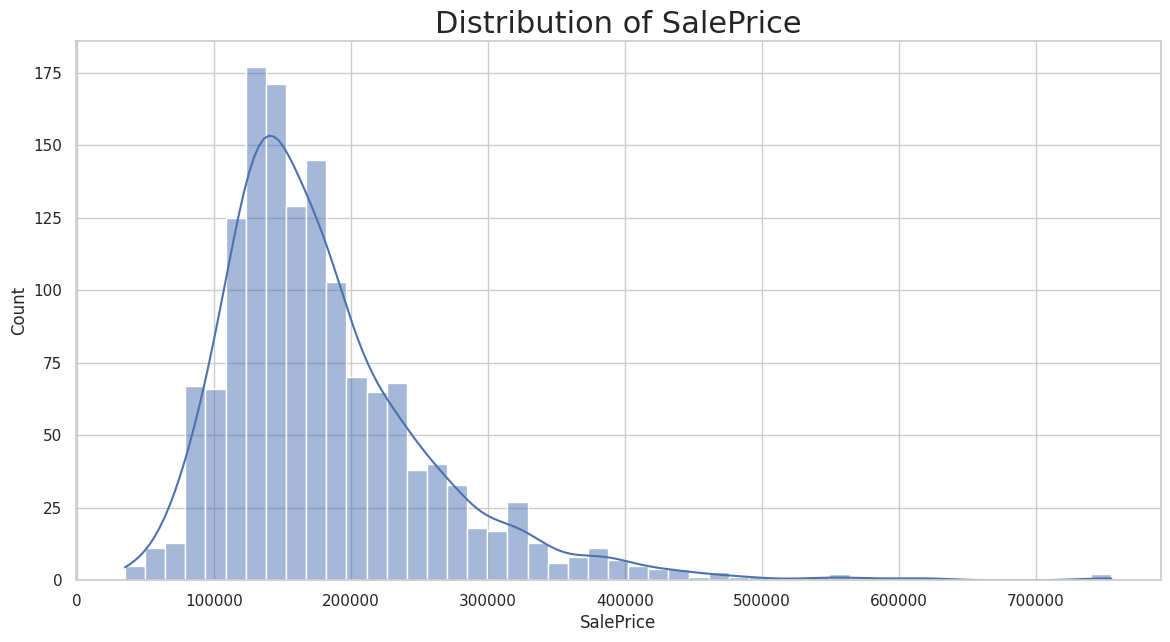

In [17]:
sns.set_theme(style="whitegrid")
target_var = "SalePrice"


def plot_target_hist(df, target_var):
    """
    Function to create histogram of the values of target.
    Save histogram into docs/plots for use in dashboard
    """
    plt.figure(figsize=(14, 7))
    sns.histplot(data=df, x=target_var, kde=True)
    plt.title(f"Distribution of {target_var}", fontsize=22)
    plt.savefig(f"docs/plots/hist_plot_{target_var}.png", bbox_inches="tight")
    plt.show()


plot_target_hist(df, target_var)

<Figure size 1400x500 with 0 Axes>

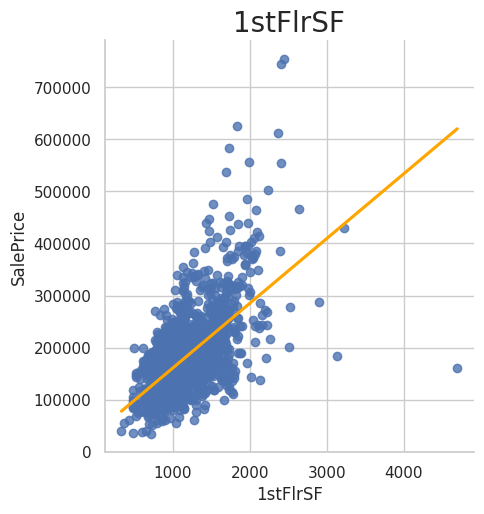

<Figure size 1400x500 with 0 Axes>

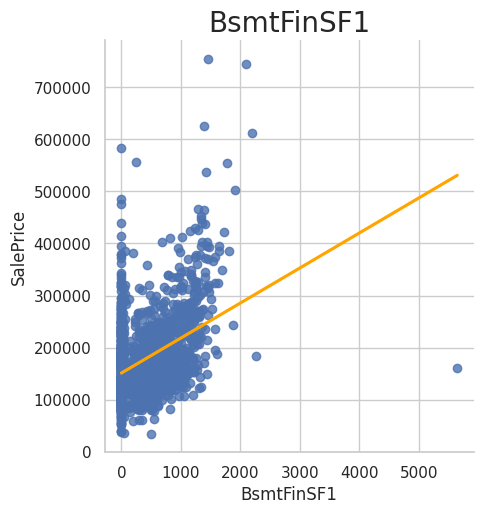

<Figure size 1400x500 with 0 Axes>

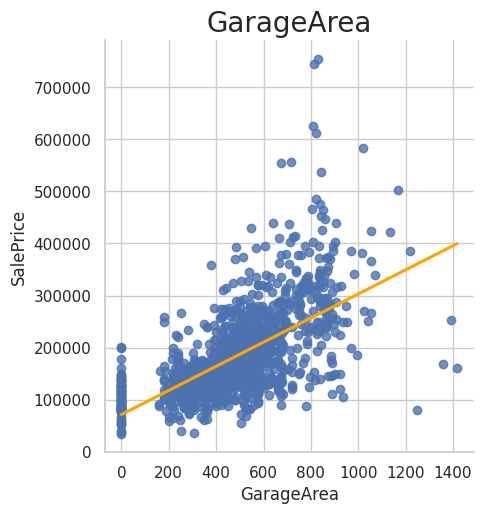

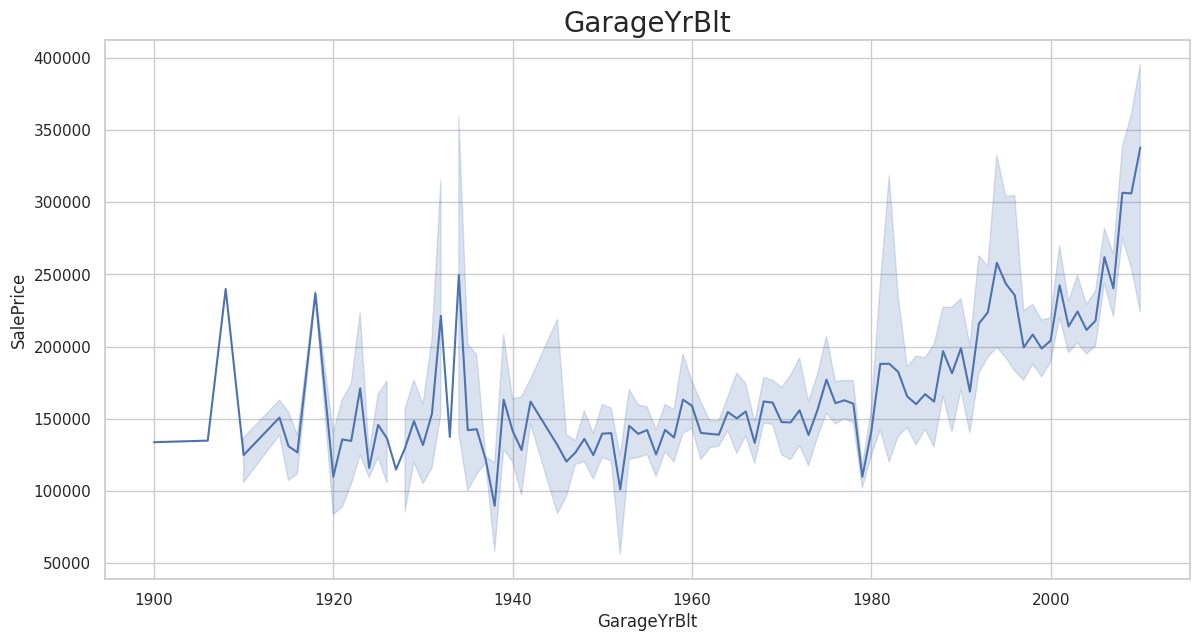

<Figure size 1400x500 with 0 Axes>

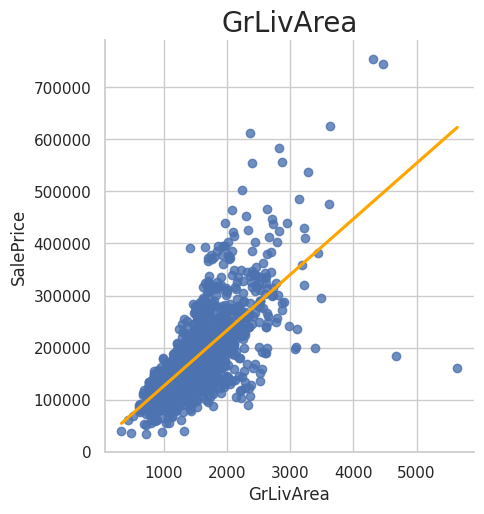

<Figure size 1400x500 with 0 Axes>

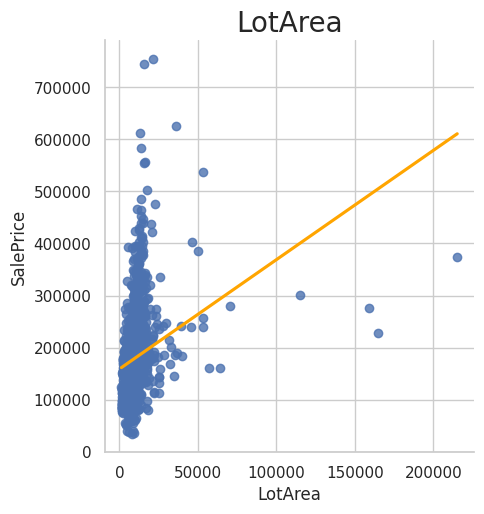

<Figure size 1400x500 with 0 Axes>

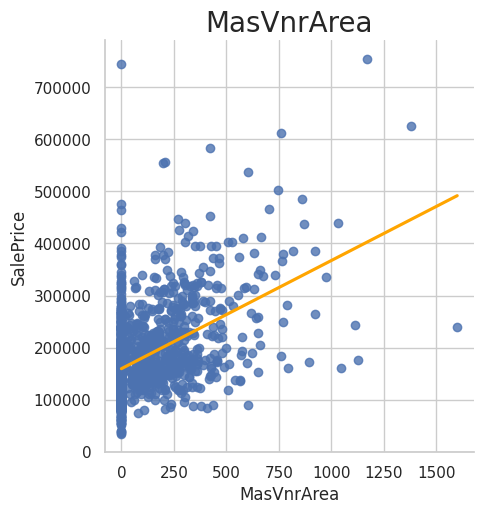

<Figure size 1400x500 with 0 Axes>

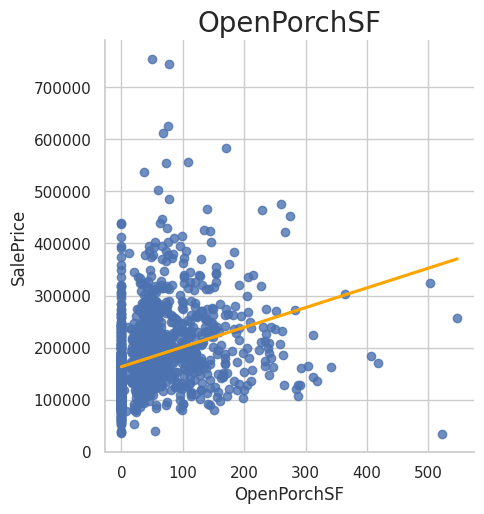

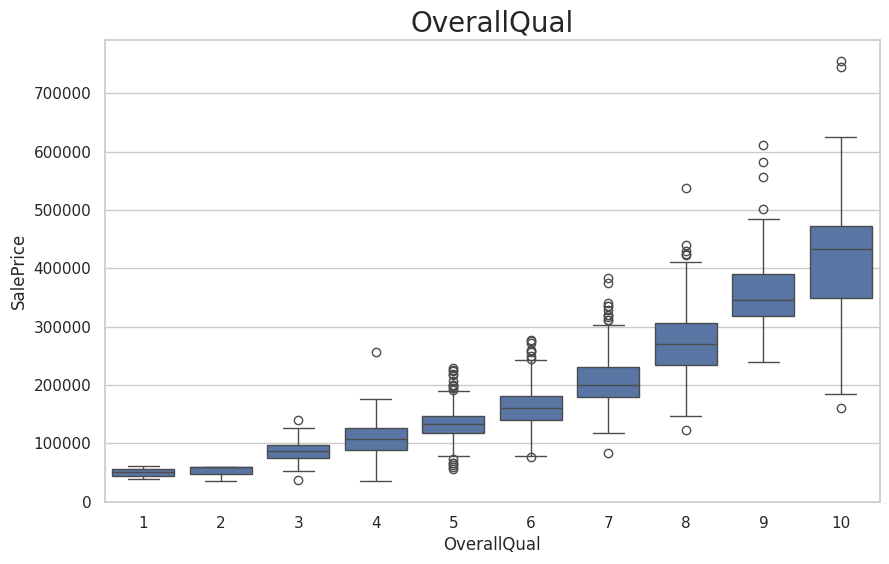

<Figure size 1400x500 with 0 Axes>

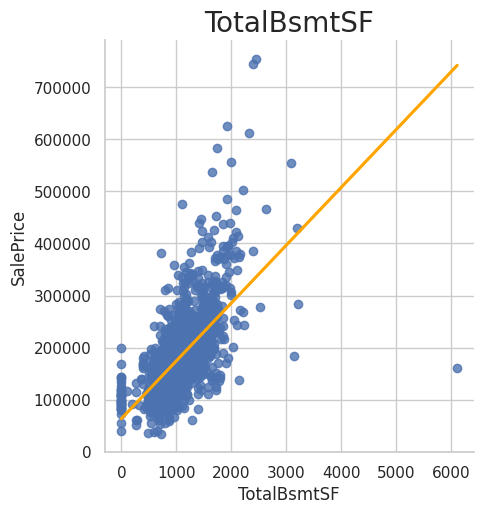

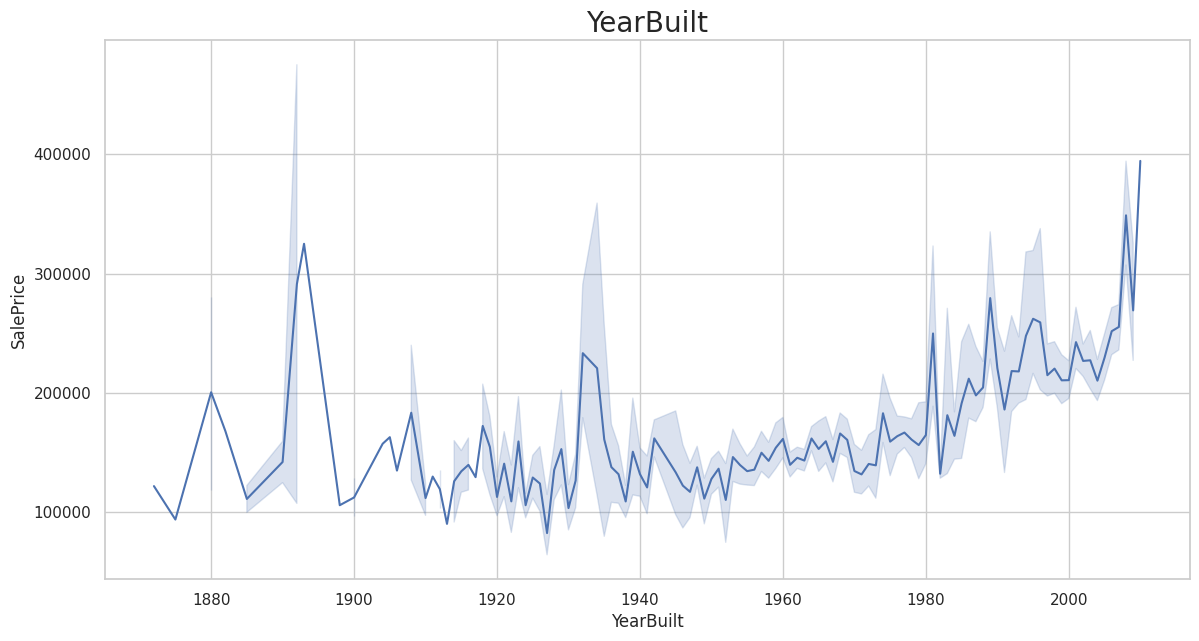

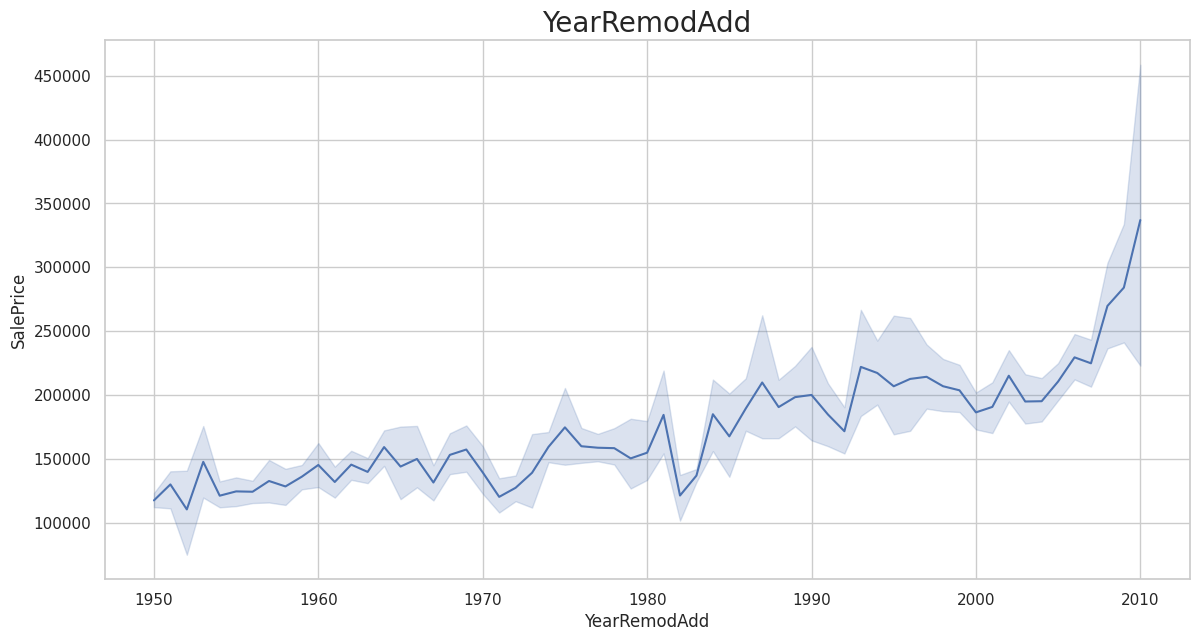

In [18]:
time = ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]


def plot_lm(df, col, target_var):
    """
    Function to create linear regression plots of the target and
    features with continuous values.
    Figures created saved to folder docs/plots
    """
    plt.figure(figsize=(14, 5))
    sns.lmplot(data=df, x=col, y=target_var, ci=None, line_kws={"color": "orange"})
    plt.title(f"{col}", fontsize=20)
    plt.savefig(f"docs/plots/lm_plot_price_by_{col}.png", bbox_inches="tight")
    plt.show()


def plot_line(df, col, target_var):
    """
    Function creates a line plot of the target and time variables.
    Figures created saved to folder docs/plots
    """
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df, x=col, y=target_var)
    plt.title(f"{col}", fontsize=20)
    plt.savefig(f"docs/plots/line_plot_price_by_{col}.png", bbox_inches="tight")
    plt.show()


def plot_box(df, col, target_var):
    """
    Function creates a box plot of the target versus categorical variables.
    Figures created saved to folder docs/plots
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col, y=target_var)
    plt.title(f"{col}", fontsize=20)
    plt.savefig(f"docs/plots/box_plot_price_by_{col}", bbox_inches="tight")
    plt.show()


for col in vars_to_study:
    if len(df_eda[col].unique()) <= 12:
        plot_box(df_eda, col, target_var)
        print("\n\n")
    else:
        if col in time:
            plot_line(df_eda, col, target_var)
            print("\n\n")
        else:
            plot_lm(df_eda, col, target_var)
            print("\n\n")

---

## Conclusions and Next Steps

**Summary**
- The correlation analysis and the plots support each other well:
    - YearBuilt and GarageYrBlt show a moderate influence on SalePrice, with a stronger effect after 1980—the newer the property, the higher the price tends to be. 
    - Outliers are present in every variable analyzed, which may influence model performance and require handling in the next stage.
    - Size-related features like GrLivArea, TotalBsmtSF, and 1stFlrSF show stronger correlations with SalePrice compared to other types of variables, suggesting they are key predictors.

**Next Steps**:
- Feature Engineering Notebook to create and validate new features for modeling.

